In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
# load data
df = pd.read_csv('../台灣電力公司_過去電力供需資訊.csv')
df.head()
df['日期'] = pd.to_datetime(df['日期'], format='%Y%m%d')
df = df.loc[:, ['日期', '備轉容量(MW)']]
# df = df.loc[:, ['日期', '備轉容量(MW)','備轉容量率(%)','工業用電(百萬度)','民生用電(百萬度)','核一#1(萬瓩)','核一#2(萬瓩)','核二#1(萬瓩)','核二#2(萬瓩)','核三#1','核三#2','林口#1','林口#2','林口#3','台中#1','台中#2','台中#3','台中#4','台中#5','台中#6','台中#7','台中#8','台中#9','台中#10']]


df['dayofweek'] = df['日期'].dt.dayofweek

df = df.set_index('日期')
df

,備轉容量(MW),dayofweek
日期,,
2021-01-01,2767,4
2021-01-02,2936,5
2021-01-03,3037,6
2021-01-04,3032,0
2021-01-05,3067,1
...,...,...
2022-02-24,2511,3
2022-02-25,3406,4
2022-02-26,3437,5


In [3]:
df.shape

(424, 2)

In [4]:
df.isna().sum()

備轉容量(MW)     0
dayofweek    0
dtype: int64

In [5]:
n_past = 60
n_future = 14
n_features = df.shape[1]

In [6]:
train_df, test_df = df[:278], df[278:]
train_df.shape, test_df.shape

((278, 2), (146, 2))

In [7]:
train = train_df
scalers={}

for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s

test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s
train, test

D:\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
D:\Python\Python37\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
D:\Python\Python37\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

(            備轉容量(MW)  dayofweek
 日期                             
 2021-01-01 -0.514066   0.333333
 2021-01-02 -0.452320   0.666667
 2021-01-03 -0.415418   1.000000
 2021-01-04 -0.417245  -1.000000
 2021-01-05 -0.404457  -0.666667
 ...              ...        ...
 2021-10-01 -0.364998   0.333333
 2021-10-02  0.387651   0.666667
 2021-10-03 -0.313117   1.000000
 2021-10-04 -0.152722  -1.000000
 2021-10-05 -0.549507  -0.666667
 
 [278 rows x 2 columns],
             備轉容量(MW)  dayofweek
 日期                             
 2021-10-06 -0.674826  -0.333333
 2021-10-07 -0.929850   0.000000
 2021-10-08 -0.847643   0.333333
 2021-10-09  0.352941   0.666667
 2021-10-10 -0.194373   1.000000
 ...              ...        ...
 2022-02-24 -0.607600   0.000000
 2022-02-25 -0.280599   0.333333
 2022-02-26 -0.269273   0.666667
 2022-02-27 -0.162221   1.000000
 2022-02-28 -0.017172  -1.000000
 
 [146 rows x 2 columns])

In [8]:
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [9]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))

X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))
X_train.shape

(205, 60, 2)

In [10]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)
#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)
#
model_e1d1.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60, 2)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 100),        41200       ['input_1[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 14, 100)      0           ['lstm[0][0]']                   
                                                                                              

In [11]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 60, 2)]      0           []                               
                                                                                                  
 lstm_2 (LSTM)                  [(None, 60, 100),    41200       ['input_2[0][0]']                
                                 (None, 100),                                                     
                                 (None, 100)]                                                     
                                                                                                  
 lstm_3 (LSTM)                  [(None, 100),        80400       ['lstm_2[0][0]']                 
                                 (None, 100),                                               

In [12]:
# reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=128,verbose=0)

model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=100,validation_data=(X_test,y_test),batch_size=128,verbose=0)

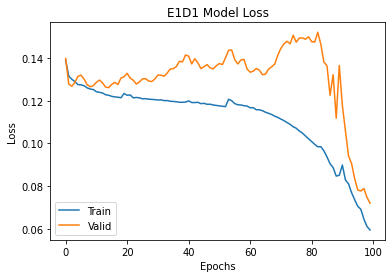

In [13]:
plt.plot(history_e1d1.history['loss'])
plt.plot(history_e1d1.history['val_loss'])
plt.title("E1D1 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

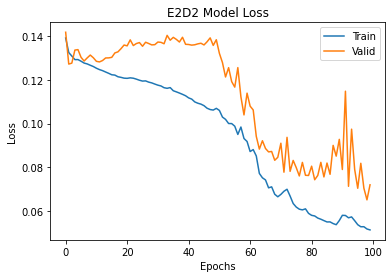

In [14]:
plt.plot(history_e2d2.history['loss'])
plt.plot(history_e2d2.history['val_loss'])
plt.title("E2D2 Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Valid'])
plt.show()

In [15]:
pred1_e1d1=model_e1d1.predict(X_test)
pred1_e2d2=model_e2d2.predict(X_test)

pred_e1d1=model_e1d1.predict(X_train)
pred_e2d2=model_e2d2.predict(X_train)

In [16]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    
    pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
    pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    
    pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
    pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [19]:
from sklearn.metrics import mean_absolute_error

for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1, n_future+1):
        print("Day ",j,":")
        # print("備轉容量(MW)1: ",mean_absolute_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]))
        print("MAE: ",mean_absolute_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
    print()
    print()

備轉容量(MW)
Day  1 :
MAE:  689.4192095194777
Day  2 :
MAE:  688.2851361836473
Day  3 :
MAE:  706.3740869809503
Day  4 :
MAE:  729.4552587221747
Day  5 :
MAE:  788.4839335402397
Day  6 :
MAE:  844.8681172410103
Day  7 :
MAE:  896.1315215646404
Day  8 :
MAE:  926.8741739351456
Day  9 :
MAE:  974.2028908925514
Day  10 :
MAE:  1006.2390939372859
Day  11 :
MAE:  1005.3025069563356
Day  12 :
MAE:  993.1541430329623
Day  13 :
MAE:  966.1685707405821
Day  14 :
MAE:  937.6659989030394


dayofweek
Day  1 :
MAE:  1.3671498192499763
Day  2 :
MAE:  1.2062870631479237
Day  3 :
MAE:  1.0746221166767487
Day  4 :
MAE:  0.9384475881106233
Day  5 :
MAE:  1.143242065220663
Day  6 :
MAE:  1.1619203286628201
Day  7 :
MAE:  0.9667961009561199
Day  8 :
MAE:  0.7108773817754772
Day  9 :
MAE:  0.5866000750293471
Day  10 :
MAE:  0.6094243812234434
Day  11 :
MAE:  0.5365528194871667
Day  12 :
MAE:  0.31062180783650645
Day  13 :
MAE:  0.4077023871957439
Day  14 :
MAE:  0.49185258803302295




In [332]:
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1, n_future+1):
        print("Day ",j,":")
        print("備轉容量(MW)1: ",mean_absolute_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]))
        print("備轉容量(MW)2: ",mean_absolute_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
        # print("備轉容量(MW)1: ", (pred1_e1d1[:,j-1,index]))
        # print("備轉容量(MW)2: ", (pred1_e2d2[:,j-1,index]))
        print('==')
    break

備轉容量(MW)
Day  1 :
備轉容量(MW)1:  [4048.6353 4076.7126 4239.7886 4162.7207 4097.322  3934.8906 3860.3218
 3858.8816 3991.5698 4180.98   4120.102  3941.4248 3763.4795 3945.2646
 3990.3657 4010.3228 4096.12   4031.0735 3889.5442 3682.0032 3614.246
 3633.1619 3736.4285 3935.8633 3911.5613 3755.5378 3713.4436 3690.4688
 3710.1729 3799.6265 3938.0715 3859.4912 3678.2993 3543.2068 3460.1287
 3495.4702 3592.9387 3702.06   3625.6157 3435.883  3258.951  3183.8325
 3187.7712 3364.1619 3502.313  3427.8506 3305.4058 3137.4182 3004.7954
 3077.8218 3159.0798 3339.6782 3309.3838 3141.3936 3051.1804 3151.6333
 3215.6946 3323.4893 3476.737  3549.868  3415.6345 3262.9688 3228.7156
 3247.5479 3355.3171 3505.3547 3502.9595 3349.8394 3196.2512 3158.9612
 3199.6956 3387.5513 3543.171 ]
==
Day  2 :
備轉容量(MW)1:  [4131.117  4131.6797 4323.107  4259.523  4205.1587 4031.9775 3947.2158
 3928.2954 4060.1946 4276.272  4224.284  4034.325  3848.0298 4055.2988
 4066.834  4057.0908 4158.9224 4108.125  3964.4336 3744.4856 36

In [341]:
a = pd.DataFrame(pred1_e1d1[-1,], columns=df.columns)
a

,備轉容量(MW),dayofweek
0,3543.170898,1.234382
1,3503.216064,2.051971
2,3500.739014,3.389017
3,3453.585449,4.633128
4,3351.601807,5.032108
5,3251.620850,3.909454
6,3208.257812,1.674407
7,3240.188232,0.306418
8,3348.603271,0.923929
9,3449.187012,2.707113


In [367]:
final_df = df[:]
final_df


,備轉容量(MW),dayofweek
日期,,
2021-12-17,6616,4
2021-12-18,4279,5
2021-12-19,3428,6
2021-12-20,2642,0
2021-12-21,2862,1
...,...,...
2022-02-24,2511,3
2022-02-25,3406,4
2022-02-26,3437,5


In [368]:
X_final, y_final = split_series(final_df.values,n_past, n_future)
X_final = X_final.reshape((X_final.shape[0], X_final.shape[1], n_features))
y_final = y_final.reshape((y_final.shape[0], y_final.shape[1], n_features))
X_final, y_final

(array([[[6616,    4],
         [4279,    5],
         [3428,    6],
         [2642,    0],
         [2862,    1],
         [3057,    2],
         [2423,    3],
         [3191,    4],
         [3035,    5],
         [3429,    6],
         [3767,    0],
         [3252,    1],
         [2807,    2],
         [4376,    3],
         [3927,    4],
         [3346,    5],
         [3641,    6],
         [3184,    0],
         [2620,    1],
         [2512,    2],
         [3209,    3],
         [3010,    4],
         [3147,    5],
         [3158,    6],
         [2491,    0],
         [2414,    1],
         [2220,    2],
         [2475,    3],
         [2681,    4],
         [2293,    5],
         [3429,    6],
         [2716,    0],
         [2425,    1],
         [3002,    2],
         [2661,    3],
         [2179,    4],
         [3032,    5],
         [2301,    6],
         [3167,    0],
         [2963,    1],
         [2549,    2],
         [3464,    3],
         [4700,    4],
         [3

In [369]:
pred_fin = model_e1d1.predict(X_final)

In [372]:
b = pd.DataFrame(pred_fin[-1,], columns=df.columns)
b

,備轉容量(MW),dayofweek
0,0.405854,-0.207253
1,-0.449651,-0.331786
2,-1.031255,-0.414133
3,-1.468399,-0.464674
4,-1.774581,-0.491659
5,-1.994947,-0.505204
6,-2.197269,-0.509355
7,-2.399933,-0.498329
8,-2.575477,-0.472177
9,-2.745973,-0.438452
